In [1]:
from modules.preamble import *

#Enter information here to access your PostgreSQL MIMIC database from Python
con = psycopg2.connect(dbname='mimic', user='postgres', password='postgres') #Your credentials for the database connector
query_schema = 'set search_path to mimiciii;' #Your search path to the MIMIC-III schema

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Preliminaries
This notebook requires you to:
* Have built the MIMIC-III postgres database (see Appendix C of the thesis for details and links on how to do this)
* Have created the explicit_sepsis table in your PostgreSQL database (script: "Explicit_sepsis.sql")
* Have created the chartevents_ss and labevents_ss tables in your PostgreSQ database (script: "Septic shock-only materialized views event tables.sql")
* Have specified your data and image directory filepaths of choice in preamble.py

The scripts can be run in multiple ways. An easy way would be to copy and paste them in the PSQL shell.

# Exploratory analysis of the filtering on septic shock
We want to know:
* How many patients have which type of sepsis according to the explicit_sepsis table
* The size of the septic shock-filtered LABEVENTS and CHARTEVENTS

In [2]:
#How many patients have which type of sepsis?
df_expls = pd.read_sql(query_schema+'select * from explicit_sepsis', con)
df_expls = df_expls.groupby('subject_id')[['severe_sepsis', 'septic_shock', 'sepsis']].max()
df_expls.sum()

severe_sepsis    3560
septic_shock     2416
sepsis           3713
dtype: int64

In [3]:
#How many records in the filtered labevents and chartevents?
count_ce_ss = pd.read_sql(query_schema + 'select count(row_id) from chartevents_ss', con).values[0][0]
count_le_ss = pd.read_sql(query_schema + 'select count(row_id) from labevents_ss', con).values[0][0]

In [4]:
print("Number of records in filtered chartevents:", '{:,}'.format(count_ce_ss))
print("Number of records in filtered labevents:", '{:,}'.format(count_le_ss))

Number of records in filtered chartevents: 32,303,461
Number of records in filtered labevents: 2,066,973


# Common Functions for Preprocessing
We define two functions that are used for both the laboratory testing and bedside monitoring events. This reduces code duplication later on.

In [5]:
#----- Function for writing a table with relevant ITEMIDS to the PostgreSQL database to 
#----- filter chartevents_ss and labevents_ss without loading them fully into memory

# Unfortunately, the connector with PostgreSQL does not work with pd.DataFrame.to_sql.
# Thus, we write a custom function to do it manually with a SQL insertion statement.

def df_itemids_to_db(df_itemids, database_connection, type_):
    """
    Creates a table in the postgres database with itemid | label | variable.
    Table names is either 'lt_var_itemids' or 'bm_var_itemids'.
    Required for filtering the chartevents and labevents tables 
        without the need to load them fully into memory.
        
    inputs
    -----
    * df_itemids: dataframe as obtained from function "find_bm_itemids" or "find_lm_itemids"
    * database_connection: database connection to the MIMIC-III PostgreSQL database.
    * type_: either 'bm' (bedside monitoring) or 'lt' (laboratory testing)
    """
    #Store values of itemid, label and variable in Python lists for later formatting
    itemids = df_itemids['itemid'].astype(str).tolist()
    labels = df_itemids['label'].tolist()
    variables = df_itemids['variable'].tolist()
    
    #Change table name according to whether bedside monitoring or laboratory testing
    if ((type_ != 'lt') & (type_ != 'bm')):
        raise Exception("Unknown type")
    if (type_=='lt'):
        table_name = 'lt_var_itemids'
    else:
        table_name = 'bm_var_itemids'
    
    #Setup the basis of the 2 sql statements: creating the table and filling it with values
    table_creation_sql = """
    CREATE TABLE """ + table_name + """ (
        itemid INT,
        label VARCHAR (50),
        variable VARCHAR (30)
    );    
    """

    table_filling_sql = """
        INSERT INTO """ + table_name + """
        (itemid, label, variable)
        VALUES
    """
    
    #Create the values in string format for sql insertion and add to query
    query_values_str = ''
    for i, (itemid, label, variable) in enumerate(zip(itemids, labels, variables)):
        if (i != len(itemids)-1):
            query_values_str += "(" + itemid + ",'" + label + "','" + variable + "'),"
        else:
            query_values_str += "(" + itemid + ",'" + label + "','" + variable + "');"

    table_filling_sql += query_values_str

    #Execute queries and commit to database
    cursor = database_connection.cursor()
    cursor.execute(query_schema + table_creation_sql)
    cursor.execute(query_schema + table_filling_sql)

    database_connection.commit()
    print('Success!')

In [6]:
#----- Function for filtering the events of septic shock patients on the desired itemids for the 
#----- laboratory testing and bedside monitoring variables

def extract_filt_events(con, type_):
    """
    Extracts events filtered on septic shock patients and the desired itemids.
    Also adds column with the variable that the observation belongs to, and converts 
    non-conforming units.
    
    dependencies:
    * PostgreSQL database tables "lt_var_itemids" and "bm_var_itemids" as from function "df_itemids_to_db"
    * PostgreSQL database tables "labevents_ss" and "chartevents_ss" tables
    
    inputs
    -----
    con: database connection to the MIMIC-III PostgreSQL database.
    type_: either 'bm' (bedside monitoring) or 'lt' (laboratory testing)
    
    notes
    -----
    * Unit conversions are hard-coded into this function for now. Not ideal, but does the job.
    """
    #DB Queries
    qry_bm = """
    SELECT c.row_id, c.subject_id, c.hadm_id, c.itemid, b.label, b.variable, c.charttime, c.valuenum, c.valueuom
    FROM chartevents_ss AS c
        INNER JOIN bm_var_itemids AS b
            ON c.itemid = b.itemid;
    """

    qry_lt = """
    SELECT le.row_id, le.subject_id, le.hadm_id, le.itemid, ltv.label, ltv.variable, le.charttime, le.valuenum, le.valueuom
    FROM labevents_ss AS le
        INNER JOIN lt_var_itemids AS ltv
            ON le.itemid = ltv.itemid;
    """
    
    #Extraction & conversion
    if ((type_ != 'lt') & (type_ != 'bm')):
        raise Exception("Unknown type")
    if (type_=='lt'):
        #Database query
        df = pd.read_sql(query_schema + qry_lt, con)
        
        #Fix unit of itemid 50889 (CRP). mg/dL -> mg/L
        mask_50889_wrong_unit = (df['itemid']==50889) & (df['valueuom']=='mg/dL')
        df.loc[mask_50889_wrong_unit, 'valuenum'] = df.loc[mask_50889_wrong_unit, 'valuenum'] * 10
    else:
        #Database query
        df = pd.read_sql(query_schema + qry_bm, con)
        
        #ITEMIDs that require unit conversion
        fahr_itemids = [678, 679, 3654, 223761]
        fio2_frac_itemids = [189, 190, 1206, 1863, 5955, 7041, 7570]
        
        #Convert temperatures in Fahrenheit to Celsius
        mask_fahr = df['itemid'].isin(fahr_itemids)
        df.loc[mask_fahr, 'valuenum'] = (df.loc[mask_fahr, 'valuenum'] - 32) * 5 / 9
        
        #Convert FiO2 as fraction to FiO2 as percentage
        mask_fio2_frac = df['itemid'].isin(fio2_frac_itemids)
        df.loc[mask_fio2_frac, 'valuenum'] = df.loc[mask_fio2_frac, 'valuenum'] * 100
        
    return df

# Laboratory Testing

## Part 1
We first narrow down to the relevant ITEMIDS:
<img src="notebook_figures/Laboratory Testing Data Conversion Flow v1 - highlighted D_LABITEMS.jpg" />

In [7]:
#-----VARIOUS INPUTS

#Dictionary for keyword search on LABEL. lt for laboratory testing.
lt_feat_dict = {
    'arterial base excess':['arterial base excess'],
    'arterial po2':['arterial oxygen saturation', 'sao2', 'o2sat', 'o2 sat', 'arterial po2', 'po2'],
    'arterial pco2':['arterial pco2','pco2'],
    'arterial ph':['arterial ph'],
    'at3':['at3', 'antithrombin'],
    'bicarbonate':['bicarbonate', 'hco3'],
    'bilirubin':['bilirubin'],
    'calcium':['calcium'],
    'creatinine':['creatinine'],
    'crp':['crp', 'c-reactive protein', 'c reactive protein'],
    'glucose':['glucose'],
    'got(asat)':['aspartate transaminase', 'aspartate aminotransferase', 'glutamic oxaloacetic transaminase',
                 'got' , 'asat', 'aspat', 'aat'],
    'gpt(alat)':['alanine transaminase', 'alanine aminotransferase', 'gpt', 'sgpt',
                 'serum glutamate-pyruvate transaminase', 'serum gluatmic-pyruvic transaminase'],
    'hematocrit':['hematocrit', 'hct'],
    'platelets':['platelets', 'thrombocytes', 'platelet count'],
    'potassium':['potassium'],
    'ptt':['ptt', 'partial thromboplastin time', 'kcct', 'kaolin-cephalin clotting time'],
    'sodium':['sodium'],
    'urea':['blood urea nitrogen', 'bun', 'urea nitrogen'],
    'white blood cells':['white blood cells', 'wbc'] #Removed leukocyte because gets undesired result
}

#Particular ITEMIDs to include regardless of whether they are in the keyword match, per feature
lt_incl_itemids={
    'arterial base excess':[50802],
    'arterial po2':[],
    'arterial pco2':[],
    'arterial ph':[50820],
    'at3':[],
    'bicarbonate':[],
    'bilirubin':[],
    'calcium':[],
    'creatinine':[],
    'crp':[],
    'glucose':[],
    'got(asat)':[50878],
    'gpt(alat)':[],
    'hematocrit':[],
    'platelets':[],
    'potassium':[],
    'ptt':[],
    'sodium':[],
    'urea':[],
    'white blood cells':[],
}

#Particular itemids to exclude completely regardless of keyword match (pollution ITEMIDs)
lt_excl_itemids = [50808, 50883, 50884, 51240, 51529, 51533]

In [8]:
#----- FUNCTION FOR FILTERING D_LABITEMS

def find_lt_itemids(feat_dict,
                    database_connection,
                    excl_itemids=None,
                    incl_itemids=None,
                    only_blood=True):
    """
    Extracts the itemids relevant for laboratory measurements from d_labitems.
    
    output
    -----
    Pandas dataframe containing the itemids, labels and fluids with their corresponding features
        (column with booleans per feature).
    
    
    inputs
    -----
    * feat_dict: dictionary {'feature_name1':['keyword1', 'keyword2', ...], ...} that maps each 
          laboratory testing feature via a set of search keywords over the "label"-columns 
          in d_items. Should all be completely lowercase.
    * database_connection: database connection to the MIMIC-III PostgreSQL database.
    * excl_itemids: optional list [itemid1, itemid2, ...] with specific itemids 
          to exclude regardless of feat_dict and categories.
    * incl_itemids: optional dictionary {'feature_name1':[itemid1, itemid2, ...], ...} with specific
          itemids to include in features regardless of feat_dict and categories.
    * only_blood: optional boolean to indicate whether we only look for itemids with fluid=blood
    
    """
    #Load d_items locally for fast, convenient processing with Python
    dfli = pd.read_sql(query_schema + """
                      SELECT row_id,
                             itemid,
                             lower(label) as label,
                             lower(fluid) as fluid
                      FROM d_labitems
                      ORDER BY row_id
                      """,
                      database_connection,
                      index_col='row_id')
    
    #Filter on blood if necessary
    if (only_blood):
        dfli = dfli[dfli['fluid']=='blood']
    
    #Initialize feature columns
    for feat_name in feat_dict.keys():
        dfli[feat_name] = False
        
    #Store specific itemids to include regardless of filtering operations for later merging
    if (incl_itemids != None):
        dfli_extra = dfli.copy(deep=True)
        for (feat_name, itemids) in incl_itemids.items():
            dfli_extra[feat_name] = dfli_extra['itemid'].isin(itemids)
    
    #Filling in columns that express to which features that the itemids belong
    for (feat_name, keywords) in feat_dict.items():
        if (len(keywords)==0):
            #If there are no keywords for this feature, skip the next step
            continue
        keyw_expr = "|".join(keywords) #Put keywords in regular expression format for querying
        dfli[feat_name] = dfli['label'].str.contains(keyw_expr).fillna(False)
        
    #Add in extra itemids from incl_itemids to features if required
    if (incl_itemids != None):
        for feat_name in feat_dict.keys():
            dfli[feat_name] = dfli[feat_name] | dfli_extra[feat_name]
            
    #Now filter the df such that it only contains itemids in the desired categories
    feat_names = list(feat_dict.keys())
    dfli = dfli[dfli[feat_names].sum(axis=1)>0]
    if (excl_itemids != None):
        dfli = dfli[~dfli['itemid'].isin(excl_itemids)] #Exclude undesired itemids
    dfli.reset_index(drop=True, inplace=True)
    
    #Additional column with string indicating variable
    dfli['variable'] = pd.Series(['' for i in range(len(dfli))])
    for feat in feat_dict.keys():
        dfli.loc[dfli[feat], 'variable'] = feat
    
    return dfli

### Filtering execution

In [9]:
#Perform the extraction based on the variable dictionary, only blood or not, included itemids & excluded itemids
df_ilm = find_lt_itemids(lt_feat_dict, 
                         con,
                         incl_itemids=lt_incl_itemids,
                         excl_itemids=lt_excl_itemids)

In [10]:
#Show how many different itemids per variable
for feat in df_ilm.columns[3:-1]:
    print(feat, df_ilm[df_ilm[feat]].shape[0])

arterial base excess 1
arterial po2 1
arterial pco2 1
arterial ph 1
at3 1
bicarbonate 2
bilirubin 1
calcium 1
creatinine 1
crp 1
glucose 2
got(asat) 1
gpt(alat) 1
hematocrit 2
platelets 1
potassium 2
ptt 1
sodium 2
urea 1
white blood cells 2


In [11]:
#View extracted ITEMIDs and their LABELs for a self-specified variable
var_name = 'urea'
df_ilm[df_ilm[var_name]]

,itemid,label,fluid,arterial base excess,arterial po2,arterial pco2,arterial ph,at3,bicarbonate,bilirubin,calcium,creatinine,crp,glucose,got(asat),gpt(alat),hematocrit,platelets,potassium,ptt,sodium,urea,white blood cells,variable
19,51006,urea nitrogen,blood,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,urea


In [12]:
#Write the resulting table with itemid | label | variable to the database
#Required in order to query the large LABEVENTS_SS table in SQL outside RAM
#Only required to be performed once (persists after kernel reboot). Execute "drop table lt_var_itemids;" if you'd like to re-do

df_itemids_to_db(df_ilm, con, 'lt')

Success!


## Part 2
Then we filter the labevents, convert units and check the outcome with the per-variable and per-ITEMID statistics.
<img src="notebook_figures/Laboratory Testing Data Conversion Flow v1 - highlighted LABEVENTS.jpg" />

In [13]:
#Execute the extraction of the filtered events. Runs in ~20 sec
df_lt = extract_filt_events(con, 'lt')

In [14]:
#LT: Let's inspect itemid statistics per variable

#Group by variable & itemid, compute statistics over valuenum
dfm = df_lt.groupby(['variable', 'itemid'])['valuenum']\
           .agg(['count', 'mean', 'std', 'min', 'median', 'max'])\
           .reset_index()

# #Add in the label name of the itemids & re-order the columns
dfm = dfm.merge(df_ilm.drop('variable', axis=1), how='left', left_on='itemid', right_on='itemid')\
         .reset_index() \
         [['variable', 'itemid', 'label'] + dfm.columns.tolist()[2:]]
dfuom = df_lt.groupby('itemid')['valueuom']\
                  .agg(lambda x: sorted(x.unique().astype(str).tolist()))\
                  .reset_index()
dfm = dfm.merge(dfuom, how='left', on='itemid')\
         .set_index(['variable', 'itemid'])

dfm.rename(columns={'valueuom':'unique values for valueuom (already converted in stats)'}, inplace=True) #Rename columns
dfm

label  count  \
variable             itemid                                               
arterial base excess 50802                           base excess  51959   
arterial pco2        50818                                  pco2  51957   
arterial ph          50820                                    ph  54494   
arterial po2         50821                                   po2  51968   
at3                  51140                          antithrombin      4   
bicarbonate          50803   calculated bicarbonate, whole blood    548   
                     50882                           bicarbonate  55478   
bilirubin            50885                      bilirubin, total  18932   
calcium              50893                        calcium, total  48965   
creatinine           50912                            creatinine  55026   
crp                  50889                    c-reactive protein    484   
glucose              50809                               glucose   9960   
                     50931                               glucose  54964   
got(asat)            50878       asparate aminotransferase (ast)  18570   
gpt(alat)            50861        alanine aminotransferase (alt)  18586   
hematocrit           50810                hematocrit, calculated   3464   
                     51221                            hematocrit  54449   
platelets            51265                        platelet count  49207   
potassium            50822                potassium, whole blood   9610   
                     50971                             potassium  58837   
ptt                  51275                                   ptt  35642   
sodium               50824                   sodium, whole blood   3033   
                     50983                                sodium  57211   
urea                 51006                         urea nitrogen  54869   
white blood cells    51300                             wbc count     63   
                     51301                     white blood cells  47362   

                                   mean          std     min  median  \
variable             itemid                                            
arterial base excess 50802    -1.609346     6.186269  -50.00   -1.00   
arterial pco2        50818    42.125873    11.716713   11.00   40.00   
arterial ph          50820     7.356668     0.099019    6.35    7.37   
arterial po2         50821   111.928629    58.037262    0.00  100.00   
at3                  51140    35.375000    25.044544    4.50   36.00   
bicarbonate          50803    21.923358     6.590501    5.00   21.00   
                     50882    23.888974     5.800225    5.00   24.00   
bilirubin            50885     4.615355     7.685143    0.00    1.40   
calcium              50893     8.219357     0.892551    1.80    8.20   
creatinine           50912     1.848652     1.603976    0.00    1.30   
crp                  50889   107.374380    77.916592    1.00   87.15   
glucose              50809   133.018373    60.274187   10.00  121.00   
                     50931   133.994014    65.804135    4.00  121.00   
got(asat)            50878   244.763382  1005.115717    3.00   50.00   
gpt(alat)            50861   150.118691   481.065489    0.00   38.00   
hematocrit           50810    30.460162     5.985556    0.00   30.00   
                     51221    28.972431     4.679285    2.10   28.50   
platelets            51265   214.866915   165.496797    5.00  180.00   
potassium            50822     4.159884     0.822812    1.40    4.00   
                     50971     4.085724     0.663767    1.80    4.00   
ptt                  51275    48.036404    26.175063   16.50   38.80   
sodium               50824   136.333663     6.883317   14.00  136.00   
                     50983   138.807048     5.667836  102.00  139.00   
urea                 51006    38.293043    27.607086    1.00   30.00   
white blood cells    51300    10.898413     8.679536    0.10    8.40   
              

CRP still has 2 distinct values in the valueuom here, but the actual numeric values of the measurement are already converted in function "extract_filt_events" (hard-coded).

Note that some observations seem unreal - however, it is much more difficult to range-check these variables compared to bedside monitoring. Therefore we leave these variables as-is without a range check for now.

In [15]:
#Store the table above to an Excel file for convenient inspection and analysis.
# dfm.to_excel(os.path.join(data_base_path, "lt-vars-itemids-stats.xlsx"))

In [16]:
#General info of the resulting filtered event table
df_lt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865988 entries, 0 to 865987
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   row_id      865988 non-null  int64         
 1   subject_id  865988 non-null  int64         
 2   hadm_id     865988 non-null  int64         
 3   itemid      865988 non-null  int64         
 4   label       865988 non-null  object        
 5   variable    865988 non-null  object        
 6   charttime   865988 non-null  datetime64[ns]
 7   valuenum    865642 non-null  float64       
 8   valueuom    865988 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 59.5+ MB


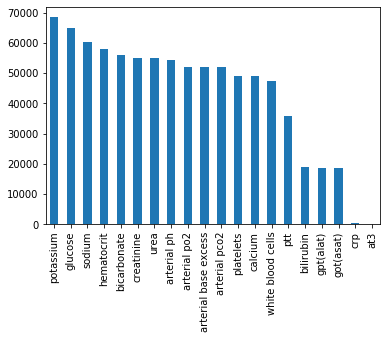

In [17]:
#How often do events of the variables occur?
df_lt['variable'].value_counts().plot(kind='bar');

In [18]:
#Let's see the above in numbers as well
df_lt['variable'].value_counts()

potassium               68459
glucose                 64936
sodium                  60247
hematocrit              57916
bicarbonate             56040
creatinine              55035
urea                    54870
arterial ph             54501
arterial po2            51976
arterial base excess    51971
arterial pco2           51965
platelets               49221
calcium                 48966
white blood cells       47466
ptt                     35800
bilirubin               18932
gpt(alat)               18586
got(asat)               18571
crp                       526
at3                         4
Name: variable, dtype: int64

In [19]:
#How many patients and hospital admissions left?
df_lt['subject_id'].nunique(), df_lt['hadm_id'].nunique()

(2414, 2584)

In [13]:
#Store for reuse in other notebooks.
# df_lt.to_hdf(path_or_buf=os.path.join(data_base_path, "cleaned_LT_events.hdf"),
#              key='Processed_data',
#              mode='w',
#              complevel=9
#             )

# Bedside Monitoring

## Part 1
We first narrow down to the relevant ITEMIDS and check UNITNAME in D_ITEMS:
<img src="notebook_figures/Bedside Monitoring Data Conversion Flow v1 - highlighted D_ITEMS.jpg" />

In [20]:
#----- VARIOUS INPUTS

#Dictionary for keyword search on LABEL. bm for bedside monitoring.
bm_feat_dict = {
    'cvp':['cvp', 'central venous pressure'],
    'diastolic blood pressure':['diastolic blood pressure', 'dbp', 'diastolic'],
    'fio2':['fraction of inspired oxygen', 'fio2', 'fo2', 'inspired o2 fraction'],
    'heart rate':['heart rate'],
    'spo2':['spo2', 'peripheral oxygen saturation', 'o2 saturation pulseoxymetry'],
    'systolic blood pressure':['systolic blood pressure', 'sbp', 'systolic'],
    'temperature':['temperature']
}

#Selected categories for filtering bedside monitoring variables on D_ITEMS.CATEGORY
bm_cats = ['cardiovascular (pulses)', 'general', 'output', 'pulmonary', 'respiratory', 'routine vital signs',
              'None']

#Particular ITEMIDs to include regardless of keyword match, per feature
bm_incl_itemids={
    'diastolic blood pressure':[],
    'fio2':[],
    'heart rate':[],
    'systolic blood pressure':[],
    'temperature':[3654, 3655],
    'spo2':[],
    'cvp':[]
}

#Particular itemids to exclude completely regardless of keyword match (pollution ITEMIDs)
bm_excl_itemids = [153, 191, 480, 482, 484, 492, 591, 597, 645, 666, 3494, 8444, 8445, 8446, 8448, 224642]

In [21]:
#----- FUNCTION FOR FILTERING D_ITEMS

def find_bm_itemids(feat_dict,
                    categories,
                    database_connection,
                    exclusion_words = [],
                    excl_itemids=None,
                    incl_itemids=None):
    """
    Extracts the itemids relevant for bedside monitoring from d_items.
    
    output
    -----
    Pandas dataframe containing the itemids, labels, categories, units and corresponding features 
        (column with booleans per feature).
    
    inputs
    -----
    * feat_dict: dictionary {'feature_name1':['keyword1', 'keyword2', ...], ...} that maps each 
          bedside monitoring feature via a set of search keywords over the "label"-columns 
          in d_items. Should all be completely lowercase.
    * categories: which categories to include from d_items. Should all be completely lowercase.
    * database_connection: database connection to the MIMIC-III PostgreSQL database.
    * exclusion_words: list of particular keywords that should be removed regardless of an earlier keyword match
    * excl_itemids: optional list [itemid1, itemid2, ...] with specific itemids 
          to exclude regardless of feat_dict and categories.
    * incl_itemids: optional dictionary {'feature_name1':[itemid1, itemid2, ...], ...} with specific
          itemids to include in features regardless of feat_dict and categories.
    
    """
    #Load d_items locally for fast, convenient processing with Python
    dfi = pd.read_sql(query_schema + """
                      SELECT row_id,
                             itemid,
                             lower(label) AS label,
                             lower(category) AS category,
                             unitname
                      FROM d_items
                      ORDER BY row_id
                      """,
                      database_connection,
                      index_col='row_id')
    
    #Initialize feature columns
    for feat_name in feat_dict.keys():
        dfi[feat_name] = False
        
    #Store specific itemids to include regardless of filtering operations for later merging
    if (incl_itemids != None):
        dfi_extra = dfi.copy(deep=True)
        for (feat_name, itemids) in incl_itemids.items():
            dfi_extra[feat_name] = dfi_extra['itemid'].isin(itemids)
            
    #Filtering on relevant categories
    dfi = dfi[dfi['category'].isin(categories) | dfi['category'].isnull()]
    
    #Filling in columns that express to which features that the itemids belong
    for (feat_name, keywords) in feat_dict.items():
        if (len(keywords)==0):
            #If there are no keywords for this feature, skip the next step
            continue
        keyw_expr = "|".join(keywords) #Put keywords in regular expression format for querying
        dfi[feat_name] = dfi['label'].str.contains(keyw_expr).fillna(False)
        
    #Remove exclusion words
    if (len(exclusion_words) != 0):
        dfi = dfi[~dfi['label'].str.contains("|".join(exclusion_words))]
    
    #Add in extra itemids from incl_itemids to features if required
    if (incl_itemids != None):
        for feat_name in feat_dict.keys():
            dfi[feat_name] = dfi[feat_name] | dfi_extra[feat_name]
            
    #Now filter the df such that it only contains itemids in the desired categories
    feat_names = list(feat_dict.keys())
    dfi = dfi[dfi[feat_names].sum(axis=1)>0]
    if (excl_itemids != None):
        dfi = dfi[~dfi['itemid'].isin(excl_itemids)] #Exclude undesired itemids
    dfi.reset_index(drop=True, inplace=True)
    
    #Additional column with string indicating variable
    dfi['variable'] = pd.Series(['' for i in range(len(dfi))])
    for feat in feat_dict.keys():
        dfi.loc[dfi[feat], 'variable'] = feat
    
    return dfi

### Filtering execution

In [22]:
#Perform the extraction based on the variable dictionary, categories, excluded keywords, included itemids & excluded itemids
df_ibm = find_bm_itemids(bm_feat_dict,
                         bm_cats,
                         con,
                         ['alarm'],
                         incl_itemids=bm_incl_itemids,
                         excl_itemids=bm_excl_itemids)

In [23]:
#Show how many different itemids per variable
for feat in df_ibm.columns[4:-1]:
    print(feat, df_ibm[df_ibm[feat]].shape[0])

cvp 2
diastolic blood pressure 17
fio2 15
heart rate 2
spo2 3
systolic blood pressure 18
temperature 10


In [24]:
#View extracted ITEMIDs and their LABELs for a self-specified variable
var_name = 'temperature'
df_ibm[df_ibm[var_name]].iloc[:,[0,1,-1]]

,itemid,label,variable
9,676,temperature c,temperature
10,677,temperature c (calc),temperature
11,678,temperature f,temperature
12,679,temperature f (calc),temperature
27,3654,temp rectal [f],temperature
28,3655,temp skin [c],temperature
49,8537,"temp/iso/warmer [temperature, degrees c]",temperature
57,223761,temperature fahrenheit,temperature
58,223762,temperature celsius,temperature
64,226329,blood temperature cco (c),temperature


In [25]:
#Unit check - look like they are the same for each feature except temperature
for feat in df_ibm.columns[4:-1]:
    print(feat, ":", df_ibm[df_ibm[feat]]['unitname'].unique())

cvp : [None]
diastolic blood pressure : [None 'mmHg']
fio2 : [None 'None']
heart rate : [None 'bpm']
spo2 : [None '%']
systolic blood pressure : [None 'mmHg']
temperature : [None '?F' '?C']


Observations
* Assume that "None" implies the same standard unit as the otherwise specified unit. 
* Apparently, we only need to convert temperature according to the check above. This conversion is performed in the function "extract_filt_events" (hard-coded).

In [26]:
#Write the resulting table with itemid | label | variable to the database
#Required in order to query the large CHARTEVENTS_SS table in SQL outside RAM
#Only required to be performed once (persists after kernel reboot). Execute "drop table ...;" if you'd like to re-do

df_itemids_to_db(df_ibm, con, 'bm')

Success!


## Part 2
Then we filter the chartevents, convert units if required, check the outcome with the per-variable and per-ITEMID statistics and perform the value range check.
<img src="notebook_figures/Bedside Monitoring Data Conversion Flow v1 - highlighted CHARTEVENTS.jpg" />

In [27]:
#Execute the extraction of the filtered events. Runs in ~1min
df_bm = extract_filt_events(con, 'bm')

In [28]:
#BM: Let's inspect itemid statistics per variable. Note that temp & fio2 are already converted despite valueuom name.

#Group by variable & itemid, compute statistics over valuenum
dfm = df_bm.groupby(['variable', 'itemid'])['valuenum']\
           .agg(['count', 'mean', 'std', 'min', 'median', 'max'])\
           .reset_index()

# #Add in the label name of the itemids & re-order the columns
dfm = dfm.merge(df_ibm.drop('variable', axis=1), how='left', left_on='itemid', right_on='itemid')\
         .reset_index() \
         [['variable', 'itemid', 'label'] + dfm.columns.tolist()[2:]]
dfuom = df_bm.groupby('itemid')['valueuom']\
                  .agg(lambda x: sorted(x.unique().astype(str).tolist()))\
                  .reset_index()
dfm = dfm.merge(dfuom, how='left', on='itemid')\
         .set_index(['variable', 'itemid'])

dfm.rename(columns={'valueuom':'unique values for valueuom (already converted in stats)'}, inplace=True) #Rename columns
dfm

label  \
variable                 itemid                                             
cvp                      113                                          cvp   
diastolic blood pressure 8364                             abp [diastolic]   
                         8368                     arterial bp [diastolic]   
                         8440                       manual bp [diastolic]   
                         8441                             nbp [diastolic]   
                         8502                         bp cuff [diastolic]   
                         8503                     bp left arm [diastolic]   
                         8504                     bp left leg [diastolic]   
                         8506                    bp right arm [diastolic]   
                         8507                    bp right leg [diastolic]   
                         8508                          bp uac [diastolic]   
                         8555                  arterial bp #2 [diastolic]   
                         220051         arterial blood pressure diastolic   
                         220180     non invasive blood pressure diastolic   
                         224643      manual blood pressure diastolic left   
                         225310                          art bp diastolic   
                         227242     manual blood pressure diastolic right   
fio2                     189                              fio2 (analyzed)   
                         190                                     fio2 set   
                         727                                  vision fio2   
                         3420                                        fio2   
                         223835                      inspired o2 fraction   
heart rate               211                                   heart rate   
                         220045                                heart rate   
spo2                     646                                         spo2   
                         220277               o2 saturation pulseoxymetry   
systolic blood pressure  6                                 abp [systolic]   
                         51                        arterial bp [systolic]   
                         442                         manual bp [systolic]   
                         455                               nbp [systolic]   
                         3313                          bp cuff [systolic]   
                         3315                      bp left arm [systolic]   
                         3317                      bp left leg [systolic]   
                         3321                     bp right arm [systolic]   
                         3323                     bp right leg [systolic]   
                         3325                           bp uac [systolic]   
                         6701                   arterial bp #2 [systolic]   
                         220050          arterial blood pressure systolic   
                         220179      non invasive blood pressure systolic   
                         224167       manual blood pressure systolic left   
                         225309                           art bp systolic   
                         227243      manual blood pressure systolic right   
temperature              676                                temperature c   
                         677                         temperature c (calc)   
                         678                                temperature f   
                         679                         temperature f (calc)   
                         3654                             temp rectal [f]   
                         3655                               temp skin [c]   
                         8537    temp/iso/warmer [temperature, degrees c]   
                         223761                    temperature fahrenheit   
                         223762                       temperatur

The ITEMIDs of FIO2 natively contains some that are percentages and some that are fractions. Although the VALUEUOM column does not indicate this in the above, the conversion of the VALUENUM column is already performed in the function "extract_filt_events" (hard-coded). Similarly, all temperature VALUENUMs are already converted to celsius.

In [29]:
#Removal of non-conforming itemids for bedside monitoring

# Select which itemids to drop
drop_bm_itemids = [6, 189, 442, 727, 3313, 3315, 3317, 3321, 3323, 3325, 3420,
                   3654, 3655, 8364, 8440, 8502, 8503, 8504, 8506, 8507, 8508,
                   8537, 224167, 224643, 227242, 227243]

# Remove from event dataframes
df_bm = df_bm[~df_bm['itemid'].isin(drop_bm_itemids)]

In [30]:
#Range check & outlier removal
shape_before = df_bm.shape

bm_ranges = {
    "cvp": [1,35],
    "diastolic blood pressure": [20,150],
    "fio2": [0,100],
    "heart rate": [0,220],
    "spo2": [30,100],
    "systolic blood pressure": [20,200],
    "temperature": [30,45]
}


for var in bm_ranges.keys():
    #Store lower & upper bounds
    low_bound = bm_ranges[var][0]
    up_bound = bm_ranges[var][1]
    
    #Obtain masks for particular variable and measurement out of range
    var_mask = df_bm['variable']==var
    out_of_range_mask = (df_bm['valuenum']<low_bound) | (df_bm['valuenum']>up_bound)
    
    #Store which indices should be removed and drop them
    drop_indices = df_bm[var_mask & out_of_range_mask].index
    df_bm.drop(drop_indices, inplace=True)
    
shape_after = df_bm.shape

print("Shape of event dataframe before and after range check:", shape_before, shape_after)

Shape of event dataframe before and after range check: (3300507, 9) (3294177, 9)


In [31]:
3300507 - 3294177

6330

Thus we only dropped a minimal amount of events, but made the value ranges much more uniform and credible (reduction of unrealistic/incorrect measurements).

In [32]:
#Rebuild & check the statistics (copy-paste of code from earlier)

#Group by variable & itemid, compute statistics over valuenum
dfm = df_bm.groupby(['variable', 'itemid'])['valuenum']\
           .agg(['count', 'mean', 'std', 'min', 'median', 'max'])\
           .reset_index()

# #Add in the label name of the itemids & re-order the columns
dfm = dfm.merge(df_ibm.drop('variable', axis=1), how='left', left_on='itemid', right_on='itemid')\
         .reset_index() \
         [['variable', 'itemid', 'label'] + dfm.columns.tolist()[2:]]
dfuom = df_bm.groupby('itemid')['valueuom']\
                  .agg(lambda x: sorted(x.unique().astype(str).tolist()))\
                  .reset_index()
dfm = dfm.merge(dfuom, how='left', on='itemid')\
         .set_index(['variable', 'itemid'])

dfm.rename(columns={'valueuom':'unique values for valueuom (already converted in stats)'}, inplace=True) #Rename columns
dfm

label  \
variable                 itemid                                          
cvp                      113                                       cvp   
diastolic blood pressure 8368                  arterial bp [diastolic]   
                         8441                          nbp [diastolic]   
                         8555               arterial bp #2 [diastolic]   
                         220051      arterial blood pressure diastolic   
                         220180  non invasive blood pressure diastolic   
                         225310                       art bp diastolic   
fio2                     190                                  fio2 set   
                         223835                   inspired o2 fraction   
heart rate               211                                heart rate   
                         220045                             heart rate   
spo2                     646                                      spo2   
                         220277            o2 saturation pulseoxymetry   
systolic blood pressure  51                     arterial bp [systolic]   
                         455                            nbp [systolic]   
                         6701                arterial bp #2 [systolic]   
                         220050       arterial blood pressure systolic   
                         220179   non invasive blood pressure systolic   
                         225309                        art bp systolic   
temperature              676                             temperature c   
                         677                      temperature c (calc)   
                         678                             temperature f   
                         679                      temperature f (calc)   
                         223761                 temperature fahrenheit   
                         223762                    temperature celsius   
                         226329              blood temperature cco (c)   

                                  count        mean        std        min  \
variable                 itemid                                             
cvp                      113     117810   12.653642   5.717269   1.000000   
diastolic blood pressure 8368    185373   58.007364  13.271567  20.000000   
                         8441    107206   55.138267  14.569074  20.000000   
                         8555      1046   57.550669  15.606183  25.000000   
                         220051  202090   57.848944  12.499193  20.000000   
                         220180  151942   59.170203  14.504427  20.000000   
                         225310   13031   56.942138  12.637834  20.000000   
fio2                     190      56048   50.007533  15.675483  20.999999   
                         223835  127336   47.284749  14.083313   0.000000   
heart rate               211     278190   89.431181  19.237676   0.000000   
                         220045  438947   94.250954  18.918733   0.000000   
spo2                     646     273708   97.049056   3.934841  30.000000   
                         220277  426691   96.463463   3.953722  30.000000   
systolic blood pressure  51      185272  115.654670  23.556429  20.000000   
                         455     107640  112.301124  21.520551  20.000000   
                         6701      1048  109.350191  20.540278  55.000000   
                         220050  202152  113.532349  21.607688  20.000000   
                         220179  152249  112.333198  20.847371  20.000000   
                         225309   13046  110.051893  21.660090  22.000000   
temperature              676      13677   37.056741   0.900056  30.700001   
                         677      65468   36.899434   0.895932  30.277800   
                         678      65456   36.899181   0.895701  30.277778   
                         679      13679   37.056883   0.900087  30.700001   
                         223761   78187   36.873633   0.866312  30.

In [33]:
#Store the table above to an Excel file for convenient inspection and analysis.
# dfm.to_excel(os.path.join(data_base_path, "bm-vars-itemids-stats.xlsx"))

### Inspecting the results

In [34]:
#General info of the resulting filtered event table
df_bm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3294177 entries, 0 to 3301692
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   row_id      int64         
 1   subject_id  int64         
 2   hadm_id     int64         
 3   itemid      int64         
 4   label       object        
 5   variable    object        
 6   charttime   datetime64[ns]
 7   valuenum    float64       
 8   valueuom    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 411.3+ MB


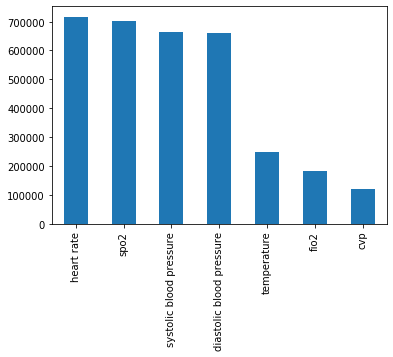

In [35]:
#How often do events of the variables occur?
df_bm['variable'].value_counts().plot(kind='bar')

In [36]:
#How many patients and hospital admissions left?
df_bm['subject_id'].nunique(), df_bm['hadm_id'].nunique()

(2392, 2556)

In [37]:
#Store for reuse in other notebooks.
# df_bm.to_hdf(path_or_buf=os.path.join(data_base_path, "cleaned_BM_events.hdf"),
#              key='Processed_data',
#              mode='w',
#              complevel=9
#             )